<a href="https://colab.research.google.com/github/raopk/Building-Transformer-Based-Natural-Language-Processing-Applications/blob/main/ML_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prep
1. Please copy the notebook first. Click "File" (top-left menu) -> Save a copy in drive. This will save a copy of this notebook to YOUR google drive (should automatically popup a new browser window after you save it)

2. Download the dataset at https://drive.google.com/file/d/1-0leZ-s74jBRPfkapuoZd0hETX8tVP3V/view?usp=sharing

This is an aggregated data file of Open University Learning Analytics Dataset. You can find more info here: https://analyse.kmi.open.ac.uk/open_dataset

3. After you download the dataset to your local computer, upload the dataset to your own copy of this colab notebook (see the screenshot) 
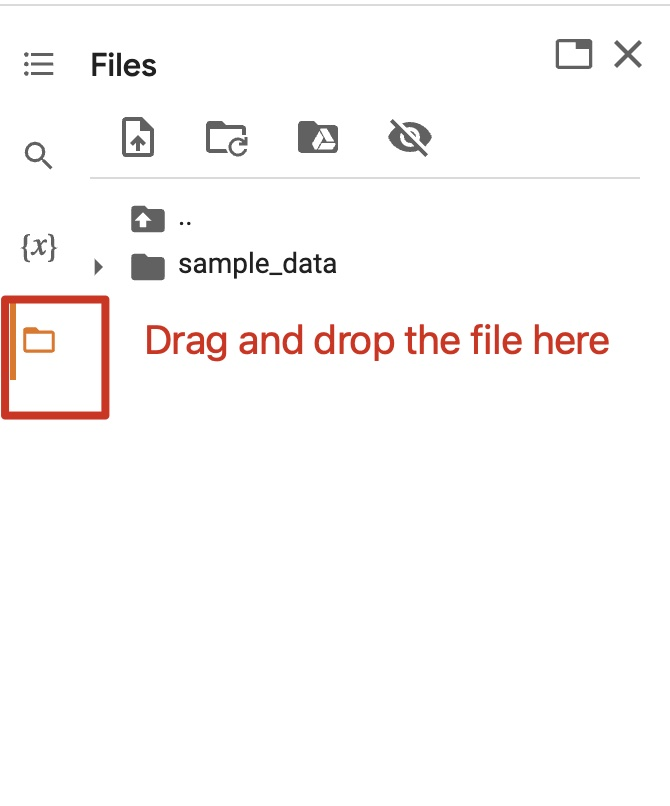

### Data Examination

Now let's take a look at the data and see what features we have

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('Module3_Dataset.csv')

In [ ]:
print(df.shape)
print(df.columns)
df.head()

(300, 16)
Index(['ID_student', 'cumulative_gpa', 'score_quiz1', 'score_quiz2',
       'score_quiz3', 'score_midterm', 'score_final', 'time_video',
       'time_material', 'time_discussion', 'message_qna', 'message_discussion',
       'message_twitter', 'assignment', 'grade_score', 'grade_letter'],
      dtype='object')


,ID_student,cumulative_gpa,score_quiz1,score_quiz2,score_quiz3,score_midterm,score_final,time_video,time_material,time_discussion,message_qna,message_discussion,message_twitter,assignment,grade_score,grade_letter
0,1,1.47,54,53,45,65,54,88.87,157.71,57.34,4,4,12,4,61.08,c
1,2,1.52,53,53,46,65,54,82.35,85.36,51.87,4,4,13,3,65.19,c
2,3,1.53,55,56,48,65,56,82.48,66.56,53.73,4,4,14,3,65.87,c
3,4,1.67,55,56,44,66,57,87.83,46.75,51.54,4,4,11,2,66.92,c
4,5,1.67,56,60,45,66,57,119.23,40.23,52.86,4,4,10,2,68.55,c


Cool! It seems that there are two columns that can be potentially used as our dependent variables: grade_score & grade_letter. One for a regression task and the other for classification!

Let's take a look at the distributions of these two columns

In [ ]:
import seaborn as sns

# The default plotting package of pandas is matplotlib, which looks very outdated
# so we use seaborn (another popular plotting package) to style our plot
sns.set_theme()

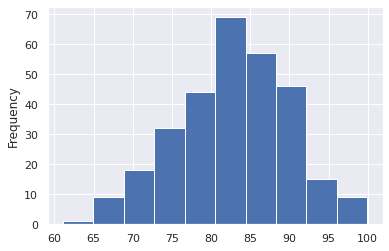

In [ ]:
# histogram of grade_score as it is continuous
df.grade_score.plot.hist()

Cool, it seems that the score is almost normally distributed. Sigh, standardized test...

In [ ]:
# let's just count grade_letter
df.grade_letter.value_counts()

b    194
a     55
c     51
Name: grade_letter, dtype: int64

Now let's get started with the real meat of building some prediction models. But before that, we want to split the data into train and test sets so that we can evaluate the models

### Train test split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
DEPENDENT_COLS = ['grade_score', 'grade_letter']
FEATURE_COLS = [col for col in df.columns if col not in DEPENDENT_COLS]

In [ ]:
DEPENDENT_COLS

['grade_score', 'grade_letter']

In [ ]:
FEATURE_COLS

['ID_student',
 'cumulative_gpa',
 'score_quiz1',
 'score_quiz2',
 'score_quiz3',
 'score_midterm',
 'score_final',
 'time_video',
 'time_material',
 'time_discussion',
 'message_qna',
 'message_discussion',
 'message_twitter',
 'assignment']

random_state below is important as we want to have reproducible split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[FEATURE_COLS], df[DEPENDENT_COLS], test_size=0.3, random_state=1234)

In [ ]:
X_train.head()

,ID_student,cumulative_gpa,score_quiz1,score_quiz2,score_quiz3,score_midterm,score_final,time_video,time_material,time_discussion,message_qna,message_discussion,message_twitter,assignment
48,49,2.44,62,67,57,71,65,212.08,56.71,87.95,4,4,9,4
193,194,3.36,72,74,68,76,74,413.50,87.34,144.12,10,16,10,10
13,14,2.00,58,62,49,69,60,176.26,57.25,64.16,5,5,9,0
32,33,2.29,61,58,55,70,63,195.17,76.31,77.06,6,7,8,2
63,64,2.55,68,68,59,72,66,210.20,58.39,74.41,5,5,10,5


Note that we have two columns for y_train and y_test. We will need to specify one column based on the prediction task (classification or regression)

In [ ]:
y_train.head()

,grade_score,grade_letter
48,74.68,c
193,84.10,b
13,70.32,c
32,74.98,c
63,78.52,b


Alright...enough being said...talk is cheap, show me the code! Let's do some classification first. We will use `grade_letter` as the dependent variable.

### Classification

In this exercise, we will examine the predictive power of three models, decision tree, support vector machine, and random forest. We will also use k-fold cross validation and grid search to help enhance the robustness of our models. There are better optimization (e.g., more effective) strategies such as Bayesian search. But we will not cover it today. Feel free to [test it out](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html). The training and evaluation process can be visualzed as

<img src="https://929687.smushcdn.com/2633864/wp-content/uploads/2021/03/hyperparameter_tuning_cv_grid_search-e1615719602429.png?lossy=1&strip=1&webp=1" width="450"/>

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="450"/>


#### Specify parameters for grid search

The selected parameters are for demo purpose only and are not very meticulous. To achieve the best result, you will want to have iterative experiments with different hyperparameters. Meanwhile, there might be room for feature engineering for improvement.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
parameters = {
    'Decision Tree': {
        "max_depth": [None, 5, 20, 50, 100],
        "min_samples_split": [2, 4, 8, 16]
    },
    'SVC': {
        "kernel": ["linear", "rbf"],
        'C':[1, 10, 30]
    },
    'Random Forest': {
        "n_estimators": [100, 200, 300, 500],
        "max_depth": [None, 5, 20, 50, 100],
        "min_samples_split": [2, 4, 8, 16]
    }
}

Now let's train and visualize their prediction results

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [ ]:
y_train_grade = y_train['grade_letter'].tolist()

In [ ]:
# Create list of models to be tested: Random Forest, Linear SVC, Naive Bayes & Logistic Regression
models = [DecisionTreeClassifier(), 
          SVC(), 
          RandomForestClassifier()]

# list of the names of the models tested
names = ["Decision Tree", "SVC", "Random Forest"]

# number of folds (5-fold cross validation performed for each model)
CV = 5

trained_models = {}

for model, name in zip(models, names):
  trained_models[name] = GridSearchCV(model, parameters[name], cv=CV)
  print(f"Start training {name}")
  trained_models[name].fit(X_train, y_train_grade)

Start training Decision Tree
Start training SVC
Start training Random Forest


In [ ]:
trained_models['Decision Tree'].best_params_

{'max_depth': 100, 'min_samples_split': 16}

#### Evaluation

In [ ]:
from sklearn.metrics import classification_report

for name in names:
  y_true = y_test['grade_letter'].to_list()
  y_pred = trained_models[name].predict(X_test)
  print(f'Here are the predictive accuracy of {name}')
  print(classification_report(y_true, y_pred))
  print('\n')

Here are the predictive accuracy of Decision Tree
              precision    recall  f1-score   support

           a       0.94      0.94      0.94        17
           b       0.97      0.98      0.98        62
           c       1.00      0.91      0.95        11

    accuracy                           0.97        90
   macro avg       0.97      0.94      0.96        90
weighted avg       0.97      0.97      0.97        90



Here are the predictive accuracy of SVC
              precision    recall  f1-score   support

           a       1.00      0.76      0.87        17
           b       0.92      0.97      0.94        62
           c       0.83      0.91      0.87        11

    accuracy                           0.92        90
   macro avg       0.92      0.88      0.89        90
weighted avg       0.93      0.92      0.92        90



Here are the predictive accuracy of Random Forest
              precision    recall  f1-score   support

           a       0.94      0.94      

### Regression

Now let's do some regression on predicting `grade_score`. We will use the old good multiple linear regression, SVR, and Random Forest (yes, it can be used for regression).

I will skip the grid search and cross validation for this task, and leave it as a back-home practice for you. It will be exactly the same as what we did in classification, except that we will need to specify different parameters and model for GridSearchCV

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [ ]:
regression_names = ['LR', 'SVR', 'RF']
regression_models = [LinearRegression, SVR, RandomForestRegressor]
regression_trained_models = {}

In [ ]:
for idx, name in enumerate(regression_names):
  regression_trained_models[name] = regression_models[idx]()
  regression_trained_models[name].fit(X_train, y_train['grade_score'])

#### Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for idx, name in enumerate(regression_names):
  y_true = y_test['grade_score']
  y_pred = regression_trained_models[name].predict(X_test)
  print(f'Model {name} has mean_absolute_error: {mean_absolute_error(y_true, y_pred)}, mean_squared_error: {mean_squared_error(y_true, y_pred)}, r2_score: {r2_score(y_true, y_pred)}')

Model LR has mean_absolute_error: 1.2394456021488456, mean_squared_error: 3.010460178693364, r2_score: 0.9298326847222218
Model SVR has mean_absolute_error: 1.2781591499890448, mean_squared_error: 3.684685703565869, r2_score: 0.9141179460563916
Model RF has mean_absolute_error: 0.9934044444444439, mean_squared_error: 2.455313403111112, r2_score: 0.9427719553039801


#### Visualization

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
X_1D = pca.fit_transform(df[FEATURE_COLS])
X_test_1D = X_1D[X_test.index, :]

Note that we are using PCA to compress the data to 1D, while in reality, the model is trained with multi-dimentional features. So the prediction line below is not a single straight line.

Viz for LR


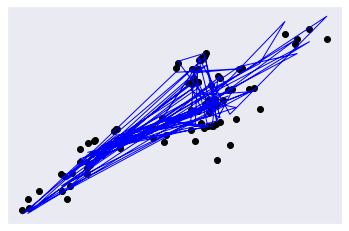

Viz for SVR


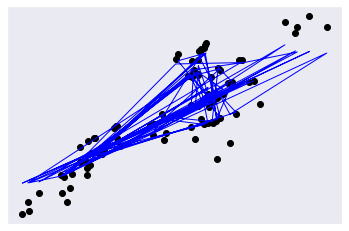

Viz for RF


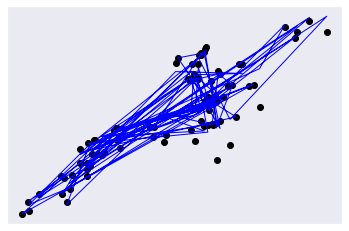

In [ ]:
for idx, name in enumerate(regression_names):
  print(f'Viz for {name}')

  y_true = y_test['grade_score']
  y_pred = regression_trained_models[name].predict(X_test)

  # Plot outputs
  plt.scatter(X_test_1D, y_true, color="black")
  plt.plot(X_test_1D, y_pred, color="blue", linewidth=1)

  plt.xticks(())
  plt.yticks(())

  plt.show()